<a href="https://colab.research.google.com/github/dpcks/playdata/blob/main/Machine_Learning/11_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XAI (Explainable Artfical Intelligence)
- 설명 가능한 AI


In [ ]:
from google.colab import drive
drive.mount("/content/dirve")

Mounted at /content/dirve


In [ ]:
DATA_PATH = "/content/dirve/MyDrive/data/"
SEED = 42

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
df = pd.read_csv(f"{DATA_PATH}titanic.csv")
# 결측치 미리 채우기
df.age = df.age.fillna(df.age.median()) # age 중앙값
df.fare = df.fare.fillna(df.fare.median()) # fare 중앙값
df.cabin = df.cabin.fillna("UNK") # cabin 임의의 문자열로 채우기
df.embarked = df.embarked.fillna(df.embarked.mode()[0]) # embarked 최빈값
# 학습에 바로 사용가능한 특성
cols = ["pclass","age","sibsp","parch","fare"]
features = df[cols]
# 범주형 one-hot encoding
cols = ["gender","embarked"]
enc = OneHotEncoder()
tmp = pd.DataFrame(
    enc.fit_transform(df[cols]).toarray(),
    columns = enc.get_feature_names_out()
)

features = pd.concat([features,tmp],axis=1) # 특성
target = df["survived"] # 정답값
features.head()

,pclass,age,sibsp,parch,fare,gender_female,gender_male,embarked_C,embarked_Q,embarked_S
0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


- HOLDOUT 으로 학습및 검증 데이터 나누기

In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_valid,y_train,y_valid = train_test_split(features,target,random_state=SEED)

x_train.shape,x_valid.shape,y_train.shape,y_valid.shape

((981, 10), (328, 10), (981,), (328,))

- lgbm 으로 학습 및 검증 평가 ✔

In [ ]:
from lightgbm import LGBMClassifier,plot_importance
from sklearn.metrics import roc_auc_score

model = LGBMClassifier(random_state = SEED)
model.fit(x_train,y_train)
pred = model.predict_proba(x_valid)[:,1]
roc_auc_score(y_valid,pred)

0.9081257023288255

- 특성(피쳐) 중요도 확인하기

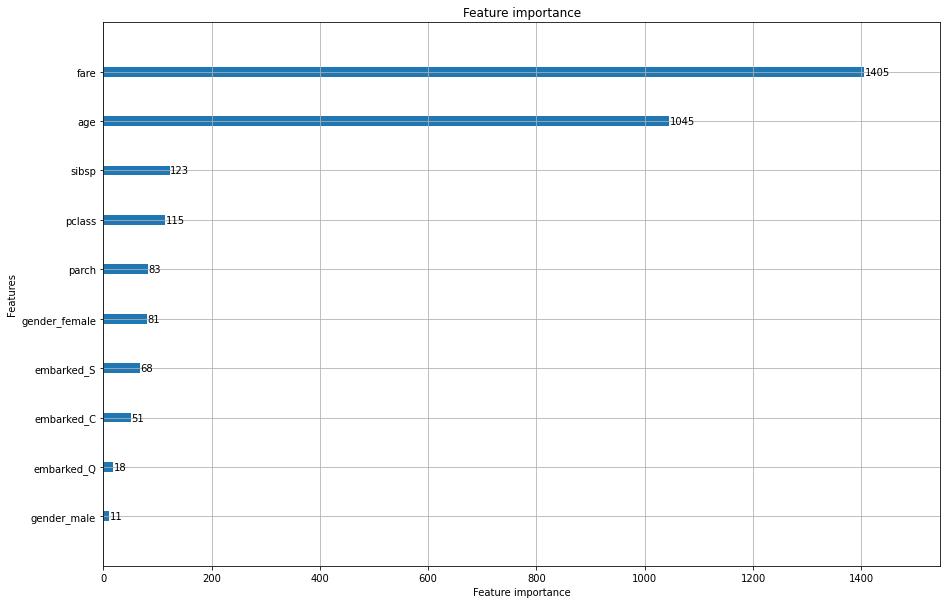

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize= (15,10))
plot_importance(model, ax=ax)
plt.show()

# SHAP(Shapley Additive exPlanations)
- Shapley Value (기여도)와 피쳐간 독립성을 핵심 아이디어로 사용하는 기법
- Shapley Value는 게임이론을 바탕으로 각 피쳐의 기여도를 계산하는 방법
- SHAP의 목적은 예측에 대한 각 피쳐의 기여도를 계산하여 관측치(X)의 예측값을 설명하는 것


- `기여도값을 주관으로 시각화해서 해석`

`게임이론`


In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 6.9 MB/s 


In [ ]:
import shap

- 주로 강사님은 트리익스플레이너 사용


In [ ]:
explainer = shap.TreeExplainer(model) # 학습된 모델을 넣는다.
shap_values = explainer.shap_values(x_valid) # 일반적으로 강사님은 검증데이터를 넣는다.

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [ ]:
shap_values # list안에 두개의 배열이 담겨있다. 첫번째 샘플에 첫번쨰 특성에 대한 기여도 이런식
# 0과 1을 예측하기위한 

[array([[ 3.43519370e-01,  2.76856108e-01, -1.46509192e-01, ...,
          1.60094090e-01,  5.37443819e-03,  1.29870449e-01],
        [-1.01818364e+00, -1.36226915e-03, -2.81918238e-01, ...,
          1.37965890e-03, -2.31098011e-03,  3.47292038e-03],
        [ 3.00808044e-01, -3.07045060e-02, -1.23233794e-01, ...,
          9.20413841e-02, -5.64413349e-03,  2.26436110e-01],
        ...,
        [-8.65193228e-01,  6.85584808e-01,  1.94237138e-03, ...,
          1.26358351e-01, -2.16673502e-04,  3.96051764e-02],
        [ 2.58714498e-01, -8.43622024e-01, -2.16339266e-01, ...,
          1.19574213e-01, -1.79965719e-03,  1.14295550e-01],
        [ 1.00449910e+00, -3.34385041e-01, -2.07858402e-01, ...,
         -3.76476839e-01,  2.74989416e-03, -2.79466546e-01]]),
 array([[-3.43519370e-01, -2.76856108e-01,  1.46509192e-01, ...,
         -1.60094090e-01, -5.37443819e-03, -1.29870449e-01],
        [ 1.01818364e+00,  1.36226915e-03,  2.81918238e-01, ...,
         -1.37965890e-03,  2.31098011e

In [ ]:
shap_values[1] # 1에 대한 예측을 확인하기 위한것

array([[-3.43519370e-01, -2.76856108e-01,  1.46509192e-01, ...,
        -1.60094090e-01, -5.37443819e-03, -1.29870449e-01],
       [ 1.01818364e+00,  1.36226915e-03,  2.81918238e-01, ...,
        -1.37965890e-03,  2.31098011e-03, -3.47292038e-03],
       [-3.00808044e-01,  3.07045060e-02,  1.23233794e-01, ...,
        -9.20413841e-02,  5.64413349e-03, -2.26436110e-01],
       ...,
       [ 8.65193228e-01, -6.85584808e-01, -1.94237138e-03, ...,
        -1.26358351e-01,  2.16673502e-04, -3.96051764e-02],
       [-2.58714498e-01,  8.43622024e-01,  2.16339266e-01, ...,
        -1.19574213e-01,  1.79965719e-03, -1.14295550e-01],
       [-1.00449910e+00,  3.34385041e-01,  2.07858402e-01, ...,
         3.76476839e-01, -2.74989416e-03,  2.79466546e-01]])

In [ ]:
len(shap_values)

2

In [ ]:
shap_values[1].shape, x_valid.shape

((328, 10), (328, 10))

- force_plot
    - 하나의 샘플을 해석하기 위한 것
    - 그 결과의 원인을 알고싶을때

In [ ]:
shap.initjs() # 초기화 해주는 것
shap.force_plot(explainer.expected_value[1],shap_values[1][-1,:],x_valid.iloc[-1,:]) #기댓값 (1에 대한) 마지막사람

- 1.50은 결정값 , 빨간색 부분이 1로 예측하기위해 확률을 높이기 위한 기여도, 파란색부분은 1로 예측하기 위해 확률을 낮추기위한 기여도
- 너비는 얼마나 기여했느냐
- 3등급이고 돈이 적으면 1로 예측하기 위한 확률을 낮추기 위한 기여도

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1],shap_values[1][0,:],x_valid.iloc[-1,:]) # 첫번쨰 사람

- summary_plot

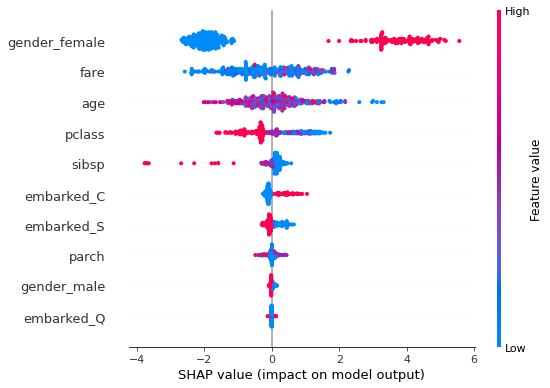

In [ ]:
shap.summary_plot(shap_values[1],x_valid)

- 0 기준으로 양수일 경우 1이 될 확률을 높이는데 기여도
- 높을수록 빨강 낮을수록 파랑 여자일수록 확률을 높이는 기여 남자일수록 확률을 낮추는데 기여
- pclass가 높을수록 즉 (3)일수록 1이 될 확률을 낮추는데 기여


- 모델기반 eda 라고 강사님 나름대로 생각. 다양하게 횔용해보아라

- dependence_plot
    - 산점도 활용

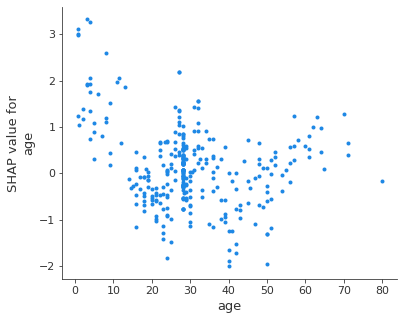

In [ ]:
shap.dependence_plot("age",shap_values[1],x_valid,interaction_index=None)

- 음의 상관관계 , 나이가 낮아질수록 확률을 높이는 기여하고 있따.
- 왼쪽위에서 오른쪽 밑으로 선형을 그리면서 내려옴 이상치 제외하고

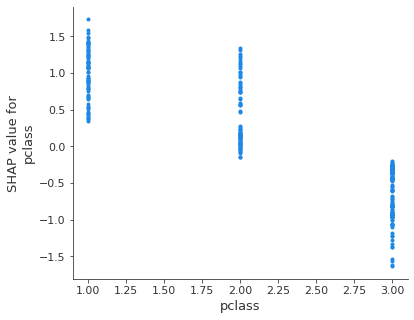

In [ ]:
shap.dependence_plot("pclass",shap_values[1],x_valid,interaction_index=None)

- 1등급일수록 확률을 높이는데 기여 , 3등급일수록 확률을 낮추는데 기여

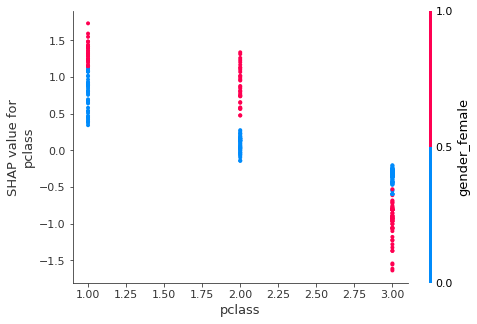

In [ ]:
shap.dependence_plot("pclass",shap_values[1],x_valid,interaction_index="auto")

- pclass와 가장 관련이 높은 특성을 자동으로 찾아줌
- 따라서 pclass는 여자인지 아닌지가 굉장히 중요
- 3등급인데 여자일경우 1일 확률을 낮추는데 기여
- 다른등급은 여자일경우 1일 확률을 높이는데 기여

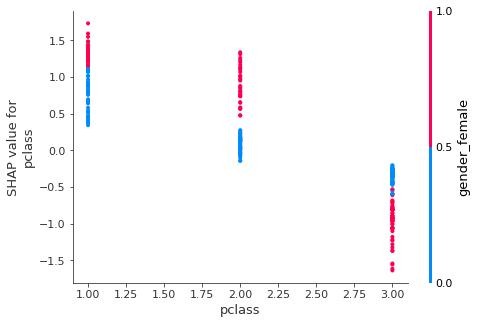

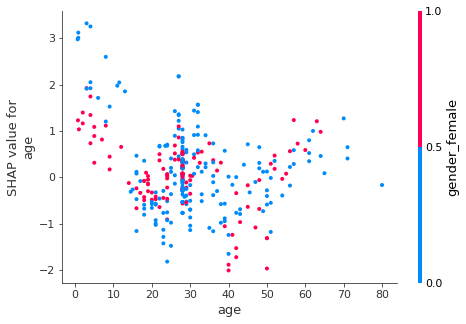

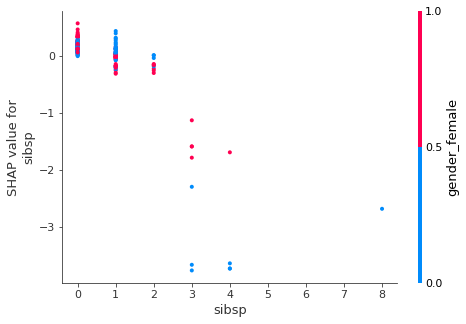

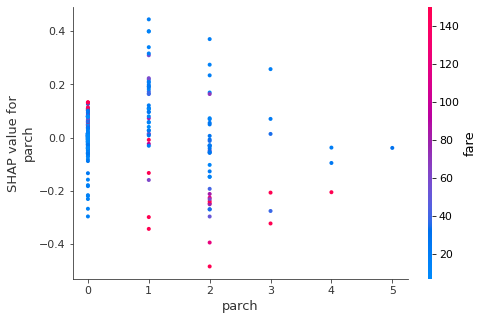

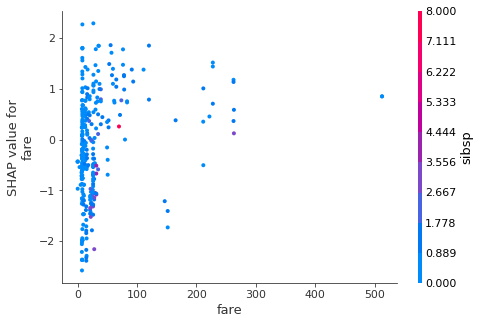

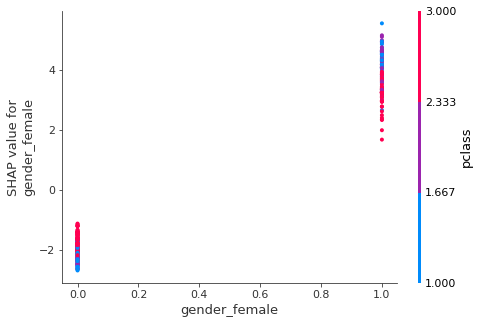

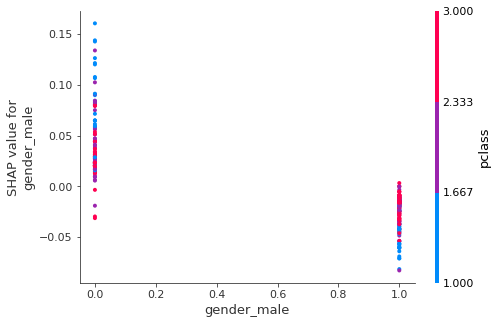

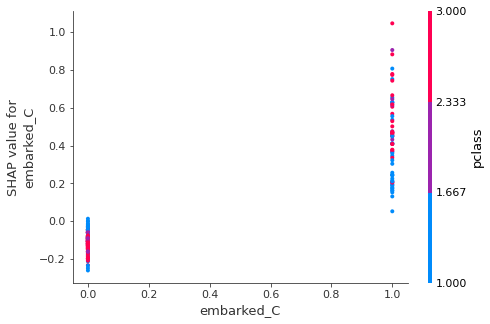

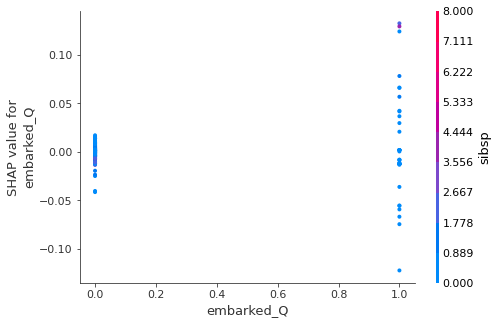

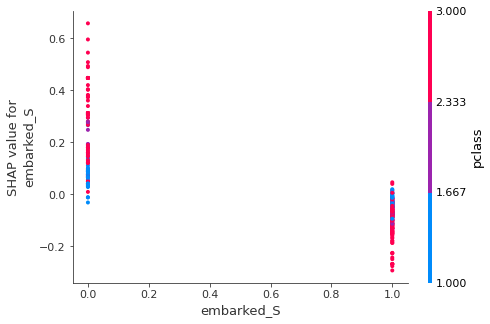

In [ ]:
for col in x_valid.columns:
    shap.dependence_plot(col,shap_values[1],x_valid)
    print()